In [1]:
#SimpliLearn_DataScience_Assignment_Retail_Analysis_with_Walmart_Data

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [3]:
#Read data and get basic info on the data
df_sales = pd.read_csv("D:\MS Data Science- Simplilearn\CSVs\Walmart_Store_sales.csv")
df_sales.info()
df_sales.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


(6435, 8)

In [4]:
#Check if any value is null
df_sales.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
#Check the data
df_sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


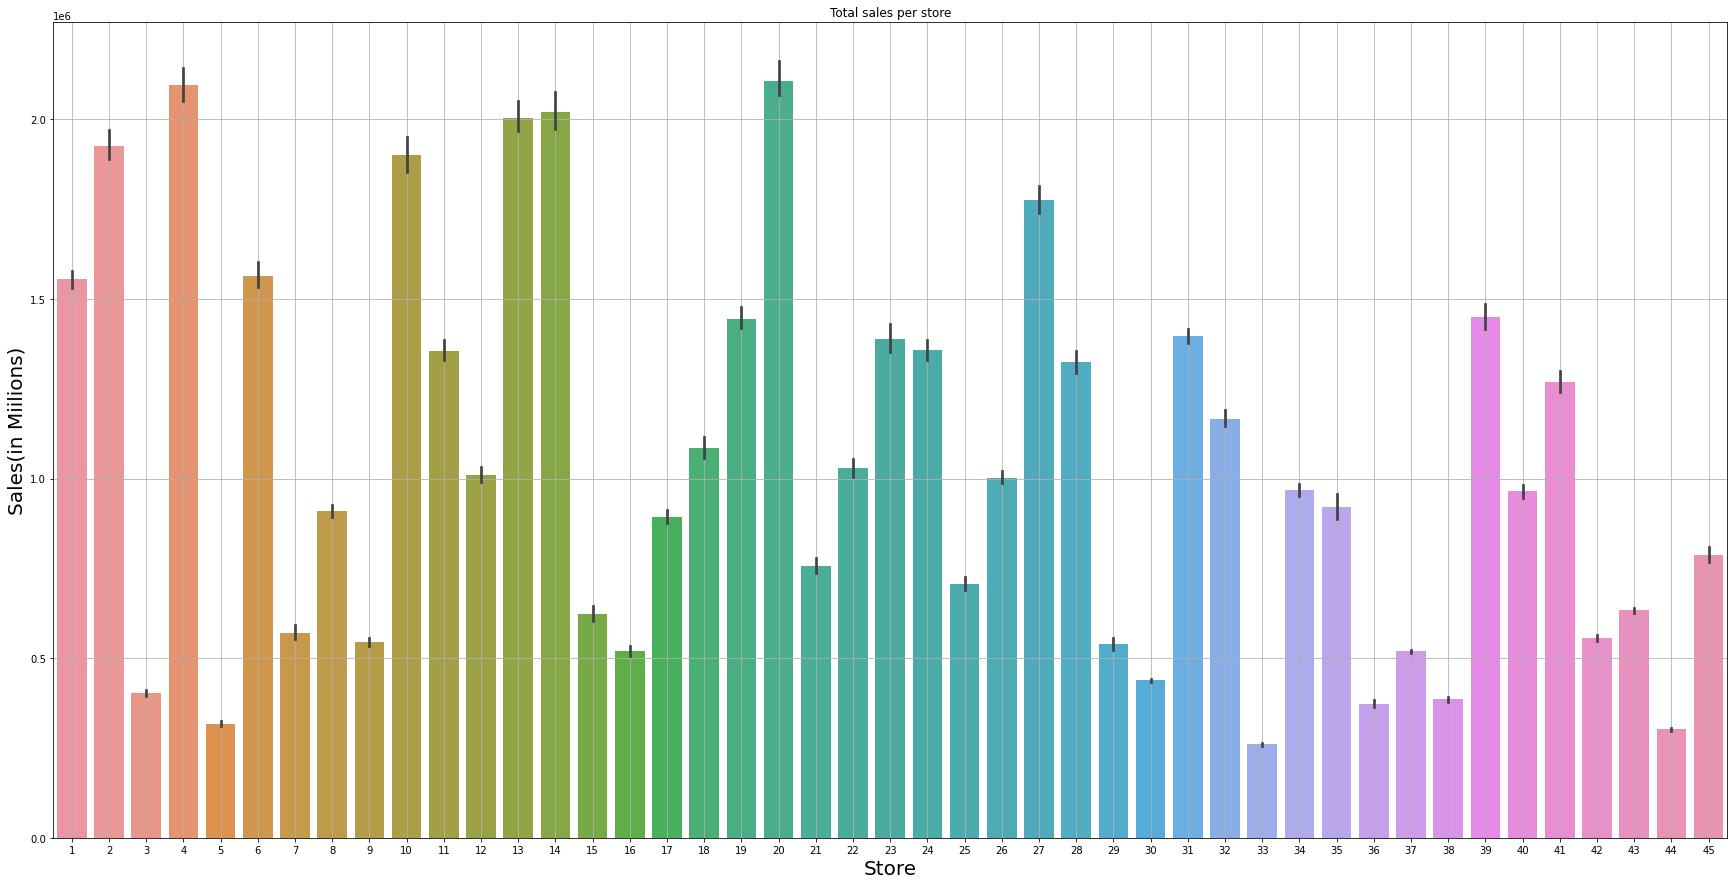

In [7]:
#Analysis_Task__Which store has maximum sales
plt.figure(figsize = (30, 15))
sns.barplot(x="Store", 
            y="Weekly_Sales", 
            data=df_sales).set_title("Total sales per store")
plt.grid()
plt.xlabel("Store", fontsize=20)
plt.ylabel("Sales(in Miilions)", fontsize=20)
plt.show()

In [8]:
max_sales = df_sales.groupby("Store")["Weekly_Sales"].sum().round().sort_values(ascending=False)
pd.DataFrame(max_sales).head(3)

,Weekly_Sales
Store,
20,301397792.0
4,299543953.0
14,288999911.0


In [9]:
#Analysis_Task__Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation
df_std = df_sales.groupby("Store").agg("std")["Weekly_Sales"].reset_index()
df_std.rename(columns = {"Weekly_Sales":"Sales_Std"}, inplace = True)

df_mean = df_sales.groupby("Store").agg("mean")["Weekly_Sales"].reset_index()
df_mean.rename(columns = {"Weekly_Sales":"Sales_Mean"}, inplace = True)

df_std["CV%"] = (df_std["Sales_Std"]/df_mean["Sales_Mean"])*100
df_std["CV%"] = round(df_std["CV%"], 2)
df_std.sort_values(by="Sales_Std", ascending = False).head()

,Store,Sales_Std,CV%
13,14,317569.949476,15.71
9,10,302262.062504,15.91
19,20,275900.562742,13.09
3,4,266201.442297,12.71
12,13,265506.995776,13.25


In [10]:
#Analysis_Task__Which store/s has good quarterly growth rate in Q3’2012
df_sales['Date'] = pd.to_datetime(df_sales['Date'], dayfirst = True)
Q3_2012 = df_sales[(df_sales['Date'] >= '2012-07-01') & (df_sales['Date'] <= '2012-09-30')]
sorted_Q3 = Q3_2012.sort_values(by = ['Store','Date'])

#Growth rate formula ((Ending Value - Starting Value) / Starting Value) x 100
start = sorted_Q3[sorted_Q3['Date'] == sorted_Q3['Date'].min()].reset_index()[['Store','Weekly_Sales']]
start.rename(columns = {'Weekly_Sales':'start_value'}, inplace = True)

end = sorted_Q3[sorted_Q3['Date'] == sorted_Q3['Date'].max()].reset_index()[['Store','Weekly_Sales']]
end.rename(columns = {'Weekly_Sales':'end_value'}, inplace = True)

growth = start.merge(end, on = 'Store')
growth['Growth%'] = round(((growth['end_value'] - growth['start_value'])/growth['start_value'])*100,2)
growth.sort_values(by = 'Growth%', ascending = False).head()

,Store,start_value,end_value,Growth%
36,37,519498.32,527953.14,1.63
43,44,358461.58,355307.94,-0.88
29,30,440553.42,425410.04,-3.44
31,32,1214183.97,1157111.15,-4.70
2,3,411206.50,389813.02,-5.20


In [11]:
#Analysis_Task__Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together
holiday_sales = df_sales[df_sales['Holiday_Flag'] == 1]
holiday_sales.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6375,45,2011-09-09,746129.56,1,71.48,3.738,186.673738,8.625
6386,45,2011-11-25,1170672.94,1,48.71,3.492,188.350400,8.523
6391,45,2011-12-30,869403.63,1,37.79,3.389,189.062016,8.523
6397,45,2012-02-10,803657.12,1,37.00,3.640,189.707605,8.424
6427,45,2012-09-07,766512.66,1,75.70,3.911,191.577676,8.684


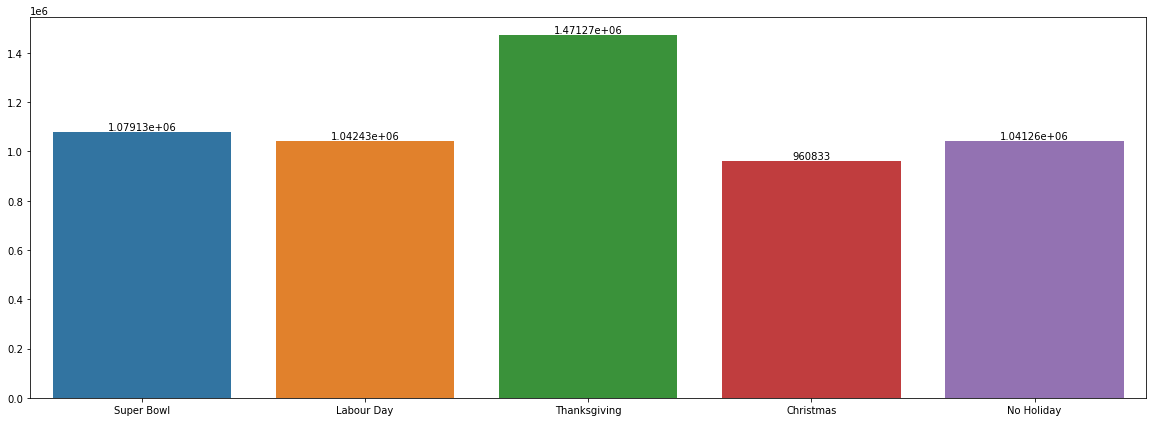

In [12]:
super_bowl = df_sales[df_sales['Date'].isin(['2010-02-12','2011-02-11','2012-02-10'])]
labour_day = df_sales[df_sales['Date'].isin(['2010-09-10','2011-09-09','2012-09-07'])]
thanksgiving = df_sales[df_sales['Date'].isin(['2010-11-26','2011-11-25','2012-11-23'])]
christmas = df_sales[df_sales['Date'].isin(['2010-12-31','2011-12-30','2012-12-28'])]
no_holiday = df_sales[df_sales['Holiday_Flag'] == 0]

y = [super_bowl['Weekly_Sales'].mean(),
    labour_day['Weekly_Sales'].mean(),
    thanksgiving['Weekly_Sales'].mean(),
    christmas['Weekly_Sales'].mean(),
    no_holiday['Weekly_Sales'].mean()]

x = ['Super Bowl',
    'Labour Day',
    'Thanksgiving',
    'Christmas',
    'No Holiday']

plt.figure(figsize = (20,7))
barplot = sns.barplot(x = x,
           y = y)

barplot.bar_label(barplot.containers[0])
plt.show()

In [13]:
#Holidays on Super Bowl, Labour Day, and Thanksgiving have higher sales than the mean sales in non-holiday season

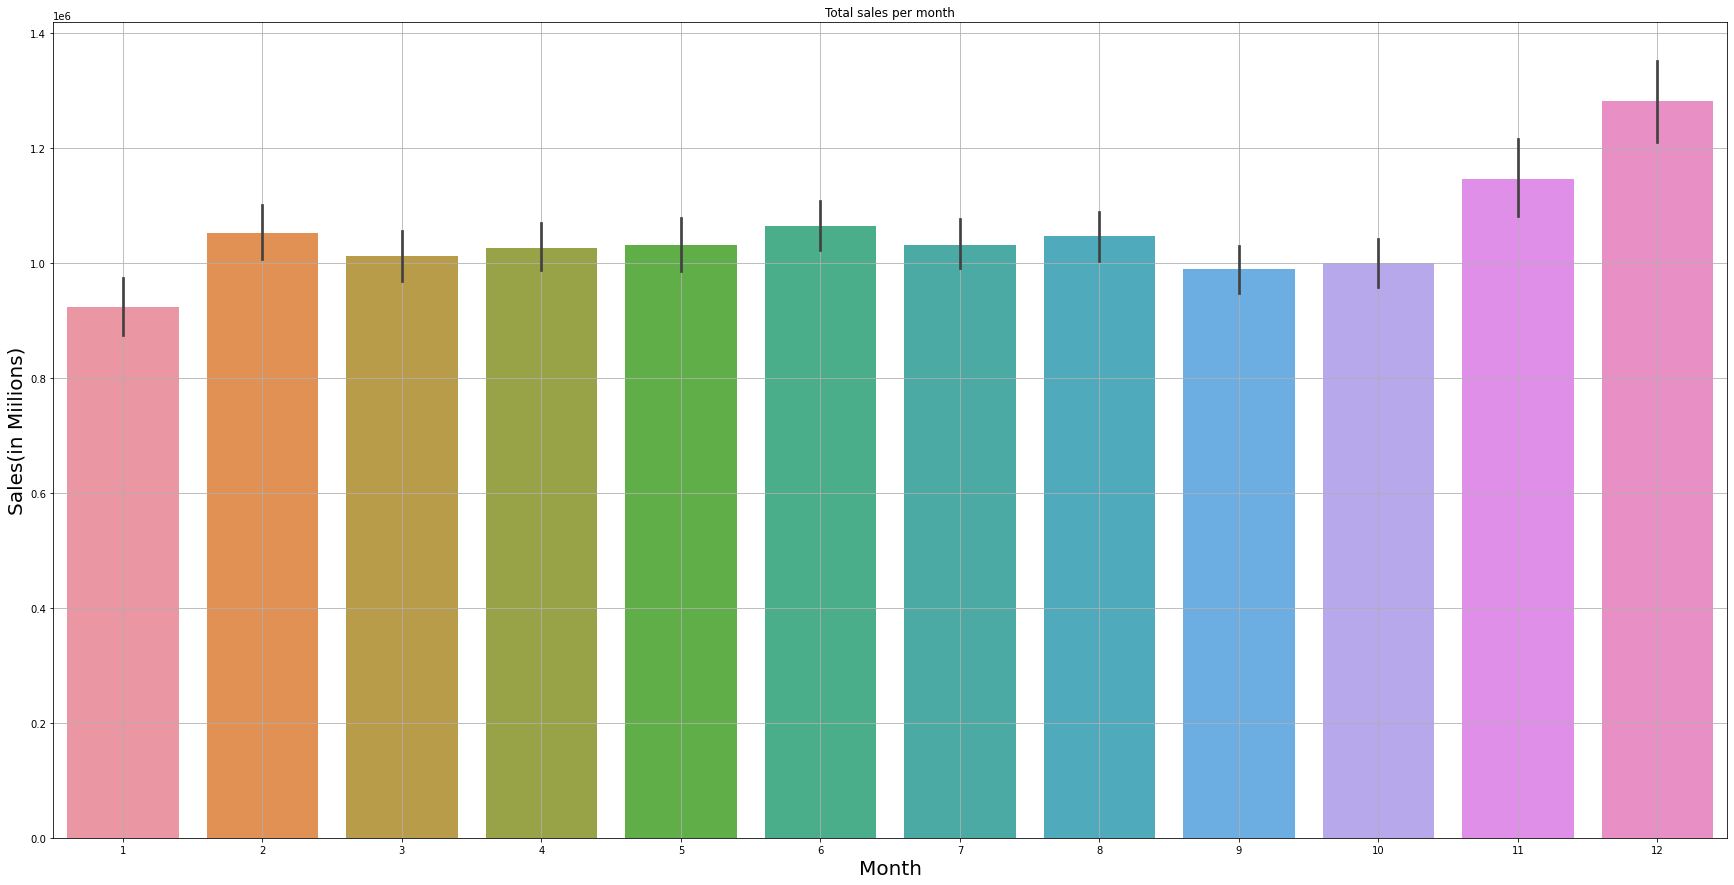

In [15]:
#Analysis_Task__Provide a monthly and semester view of sales in units and give insights
sales = df_sales.copy()
sales['year'] = sales['Date'].dt.year
sales['month'] = sales['Date'].dt.month
sales['year_month'] = list(zip(sales['month'], sales['year']))

plt.figure(figsize = (30, 15))
sns.barplot(x="month", 
            y="Weekly_Sales", 
            data=sales).set_title("Total sales per month")
plt.grid()
plt.xlabel("Month", fontsize=20)
plt.ylabel("Sales(in Miilions)", fontsize=20)
plt.show()

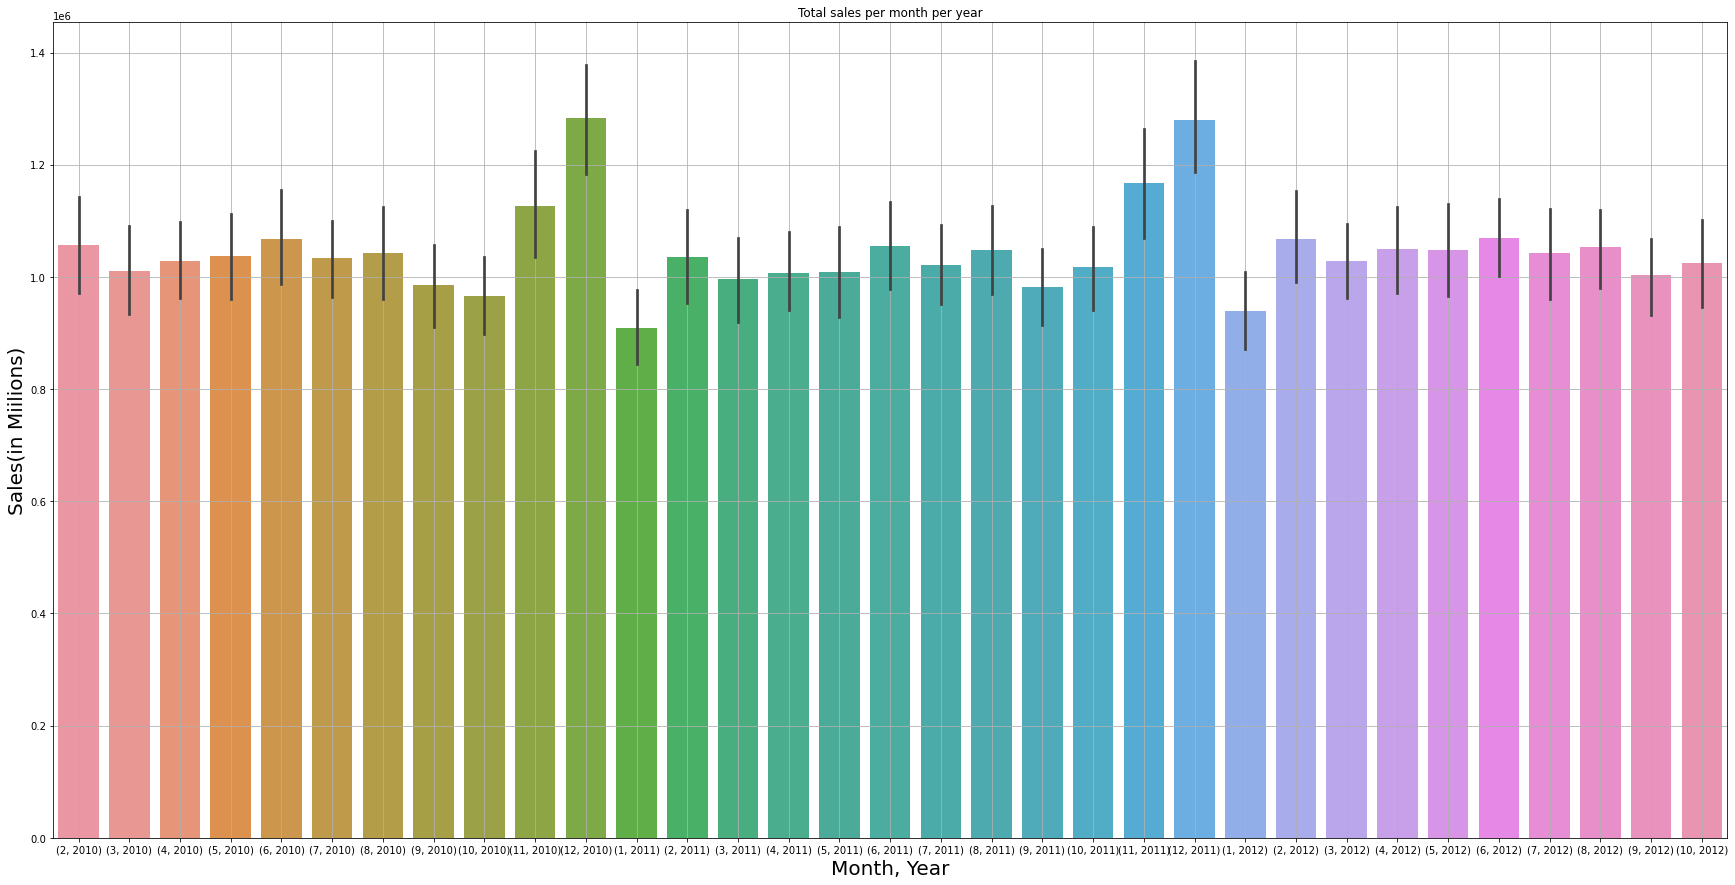

In [16]:
plt.figure(figsize = (30, 15))
sns.barplot(x="year_month", 
            y="Weekly_Sales", 
            data=sales).set_title("Total sales per month per year")
plt.grid()
plt.xlabel("Month, Year", fontsize=20)
plt.ylabel("Sales(in Miilions)", fontsize=20)
plt.show()

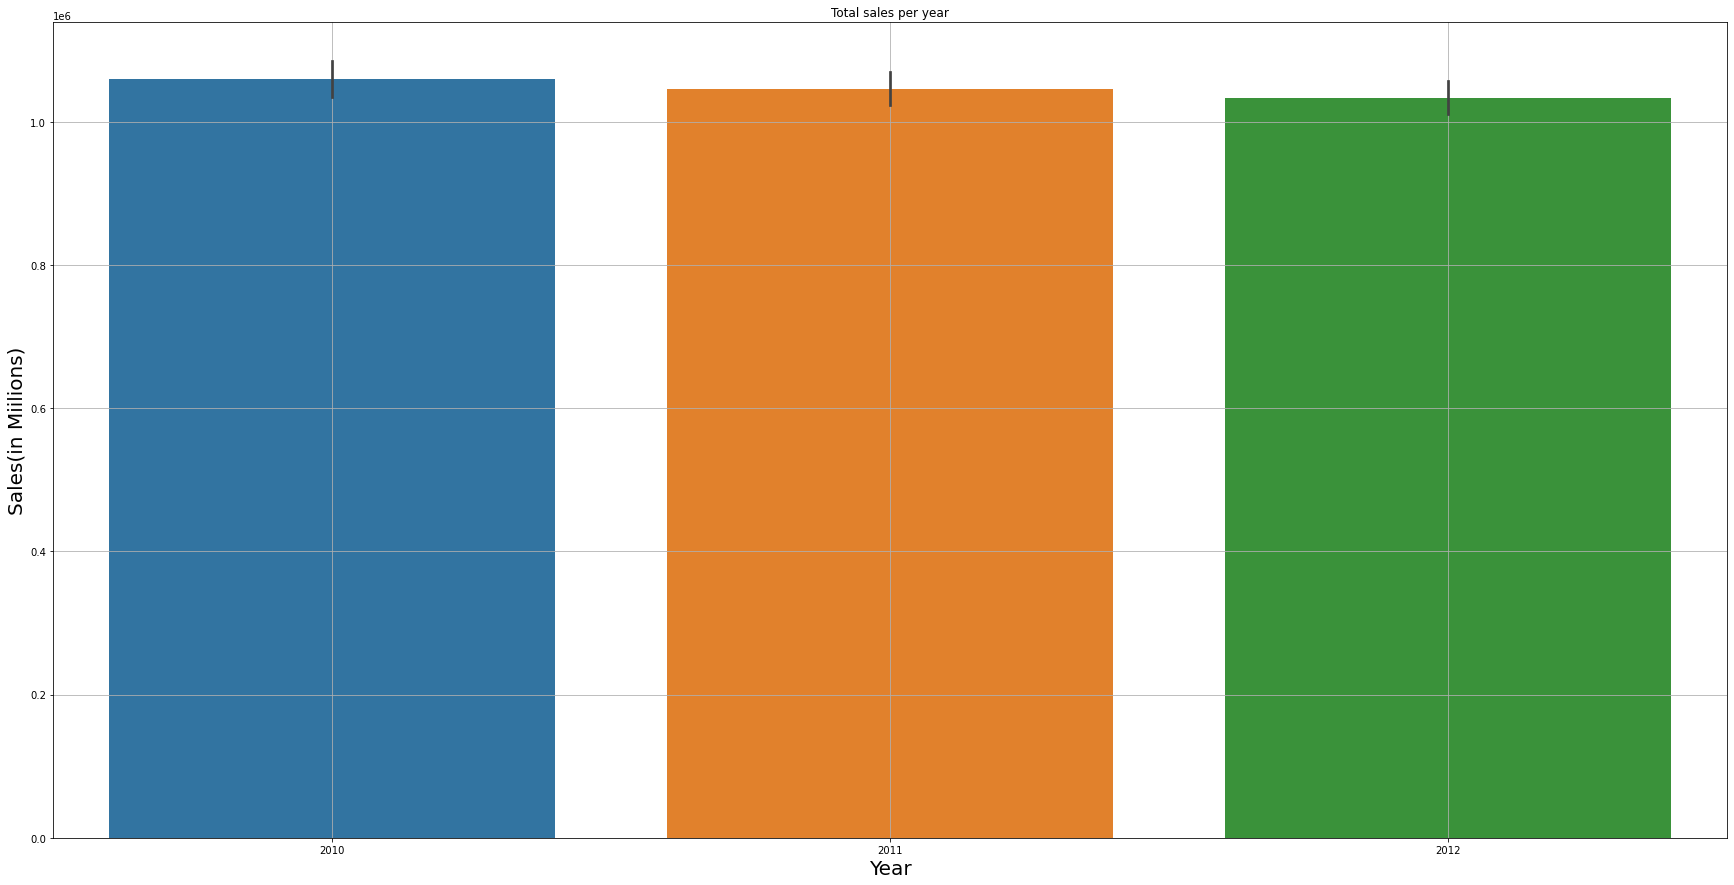

In [18]:
plt.figure(figsize = (30, 15))
sns.barplot(x="year", 
            y="Weekly_Sales", 
            data=sales).set_title("Total sales per year")
plt.grid()
plt.xlabel("Year", fontsize=20)
plt.ylabel("Sales(in Miilions)", fontsize=20)
plt.show()

In [20]:
#Statistical Model
#For Store 1 – Build  prediction models to forecast demand
#Model_Task__Linear Regression – Utilize variables like date and restructure dates as 1 for 5 Feb 2010 (starting from the earliest date in order). Hypothesize if CPI, unemployment, and fuel price have any impact on sales.
df_store1 = df_sales[(df_sales['Store'] == 1)]
df_store1.info()
df_store1.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         143 non-null    int64         
 1   Date          143 non-null    datetime64[ns]
 2   Weekly_Sales  143 non-null    float64       
 3   Holiday_Flag  143 non-null    int64         
 4   Temperature   143 non-null    float64       
 5   Fuel_Price    143 non-null    float64       
 6   CPI           143 non-null    float64       
 7   Unemployment  143 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 10.1 KB


(143, 8)

In [22]:
df_store1.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573
140,1,2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573
142,1,2012-10-26,1493659.74,0,69.16,3.506,223.444251,6.573


C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\karso\anaconda3\lib\si

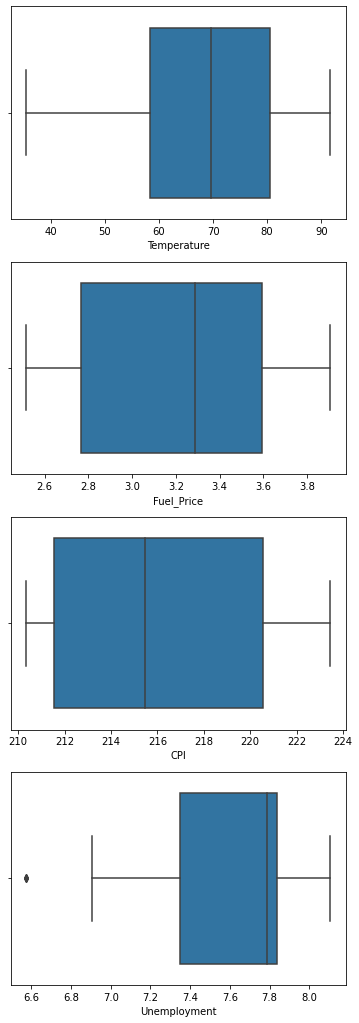

In [23]:
#Find outliers
fig, axs = plt.subplots(4,figsize=(6,18))
X = df_store1[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_store1[column], ax=axs[i])

In [26]:
#Drop outliers
df_new_store1 = df_store1[(df_store1['Unemployment'] > 6.6)]
df_new_store1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
134,1,2012-08-31,1582083.40,0,80.49,3.638,222.305480,6.908
135,1,2012-09-07,1661767.33,1,83.96,3.730,222.439015,6.908
136,1,2012-09-14,1517428.87,0,74.97,3.717,222.582019,6.908
137,1,2012-09-21,1506126.06,0,69.87,3.721,222.781839,6.908


C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\karso\anaconda3\lib\si

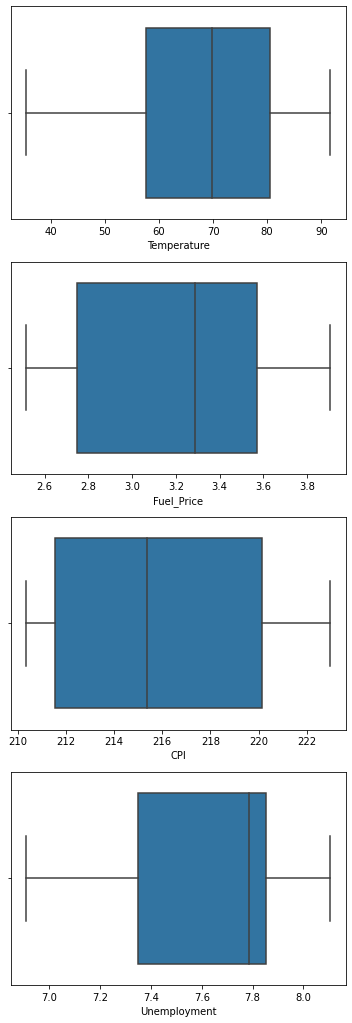

In [27]:
#Check again for outliers
fig, axs = plt.subplots(4,figsize=(6,18))
X = df_new_store1[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_new_store1[column], ax=axs[i])

Linear Regression:

Accuracy: 5.455914304325516
Mean Absolute Error: 95230.56358470842
Mean Squared Error: 13671053611.526096
Root Mean Squared Error: 116923.28087907085


C:\Users\karso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


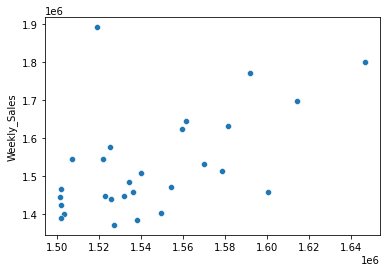

In [31]:
#Build and train model for Linear regression
X = df_new_store1[['Fuel_Price','CPI','Unemployment']]
y = df_new_store1['Weekly_Sales']

# Split data to train and test (0.80:0.20)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print('Linear Regression:')
print()
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('Accuracy:',reg.score(X_train, y_train)*100)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

sns.scatterplot(y_pred, y_test);

In [32]:
#Model_Task__Change dates into days by creating new variable.
store1 = df_sales[df_sales['Store'] == 1].sort_values(by = 'Date', ascending = True)

def date_to_days(df):
    days = []
    for i in df:
        convert = (i - df[0]).days
        days.append(convert)
    days[0] = 1
    return days
store1['days'] = date_to_days(store1['Date'])
store1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,days
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,7
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,14
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,21
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,28
...,...,...,...,...,...,...,...,...,...
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908,966
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573,973
140,1,2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573,980
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573,987
